In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

# Path to your Google Drive - create/change directory as needed
drive_path = '/content/gdrive/MyDrive/MSDS629_Project/'

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

from itertools import product

from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.interpolate import griddata

# 0.0 Generating .csv to run experiments

## 0.1 Experiment 1 - min, max

In [ ]:
tile_sizes = np.arange(0.1, 0.51, 0.4) # 0.1 to 0.5 in 0.4 increments
match_scores = range(50, 101, 50) # 0 to 100 in 50 increments
preview_lengths = range(30, 121, 90) # 30 to 120 in 90 second increments
preview_types = ['TT', 'AC']

param_grid = product(tile_sizes, match_scores, preview_lengths, preview_types)
df_param = pd.DataFrame(param_grid, columns=['Tile.Size', 'Match.Score', 'Prev.Length', 'Prev.Type'])

# center point
df_param.loc[len(df_param)] = [0.3, 75, 75, 'TT']
df_param.loc[len(df_param)] = [0.3, 75, 75, 'AC']

df_param

,Tile.Size,Match.Score,Prev.Length,Prev.Type
0,0.1,50,30,TT
1,0.1,50,30,AC
2,0.1,50,120,TT
3,0.1,50,120,AC
4,0.1,100,30,TT
5,0.1,100,30,AC
6,0.1,100,120,TT
7,0.1,100,120,AC
8,0.5,50,30,TT
9,0.5,50,30,AC


In [ ]:
# Note the directory to retrieve file
df_param.to_csv('/content/gdrive/MyDrive/MSDS629_Project/td8sdswt.csv', index=False)

## 0.2 Experiment 2 - face centered design

In [ ]:
match_scores = [50, 100, 50, 100, 75, 75, 75, 75]
prev_length = [75, 75, 75, 75, 30, 120, 30, 120]
prev_types = ['TT', 'TT', 'AC', 'AC', 'TT', 'TT', 'AC', 'AC']

df_param_2 = pd.DataFrame({'Match.Score': match_scores,
                           'Prev.Length': prev_length,
                           'Prev.Type': prev_types})

df_param_2

,Match.Score,Prev.Length,Prev.Type
0,50,75,TT
1,100,75,TT
2,50,75,AC
3,100,75,AC
4,75,30,TT
5,75,120,TT
6,75,30,AC
7,75,120,AC


In [ ]:
# Note the directory to retrieve file
df_param_2.to_csv('/content/gdrive/MyDrive/MSDS629_Project/td8sdswt.csv', index=False)

## 0.3 Experiment 3 - Confirmation

# 1.0 2^k factorial testing to confirm that tile_size is not important

## 1.1 Read in the experiment .csv and process dataframe

In [ ]:
# CSV with min and max match_score and prev_length
# csv_2k = drive_path + 'RESULTS_NSTEVENS_CumCondCount=89140_2024-01-15.csv' # min max values
# csv_exp1 = drive_path + 'RESULTS_NSTEVENS_CumCondCount=93892_2024-01-18.csv'
# csv_exp1 = drive_path + 'RESULTS_NSTEVENS_CumCondCount=93878_2024-01-19.csv'
csv_exp1 = drive_path + 'RESULTS_td8sdswt_CumCondCount=18_2024-01-19.csv'

In [ ]:
df_2k = pd.read_csv(csv_exp1)
df_2k = df_2k.rename(columns={
    'Tile.Size': 'tile_size',
    'Match.Score': 'match_score',
    'Prev.Length': 'prev_length',
    'Prev.Type': 'prev_type',
    'Browse.Time': 'browse_time'
})
df_2k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tile_size    1800 non-null   float64
 1   match_score  1800 non-null   int64  
 2   prev_length  1800 non-null   int64  
 3   prev_type    1800 non-null   object 
 4   browse_time  1800 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 70.4+ KB


In [ ]:
df_2k_mean = df_2k.groupby(['match_score', 'prev_length', 'prev_type'])['browse_time'].mean()
df_2k_mean

match_score  prev_length  prev_type
50           30           AC           21.777024
                          TT           16.875266
             120          AC           22.449678
                          TT           17.500261
75           75           AC           14.997825
                          TT            9.959197
100          30           AC           21.824460
                          TT           16.848157
             120          AC           25.058940
                          TT           20.015655
Name: browse_time, dtype: float64

## 1.2 Create Main Effect and Interaction Term Plots

In [ ]:
# Main effect for match_score
y_ms_50 = df_2k.groupby(['match_score']).get_group(50)['browse_time'].mean()
y_ms_100 = df_2k.groupby(['match_score']).get_group(100)['browse_time'].mean()

# Main effect for prev_length
y_pl_30 = df_2k.groupby(['prev_length']).get_group(30)['browse_time'].mean()
y_pl_120 = df_2k.groupby(['prev_length']).get_group(120)['browse_time'].mean()

# Main effect for prev_type
y_pt_tt = df_2k.groupby(['prev_type']).get_group('TT')['browse_time'].mean()
y_pt_ac = df_2k.groupby(['prev_type']).get_group('AC')['browse_time'].mean()

# Main effect for tile_size
y_ts_01 = df_2k.groupby(['tile_size']).get_group(0.1)['browse_time'].mean()
y_ts_05 = df_2k.groupby(['tile_size']).get_group(0.5)['browse_time'].mean()

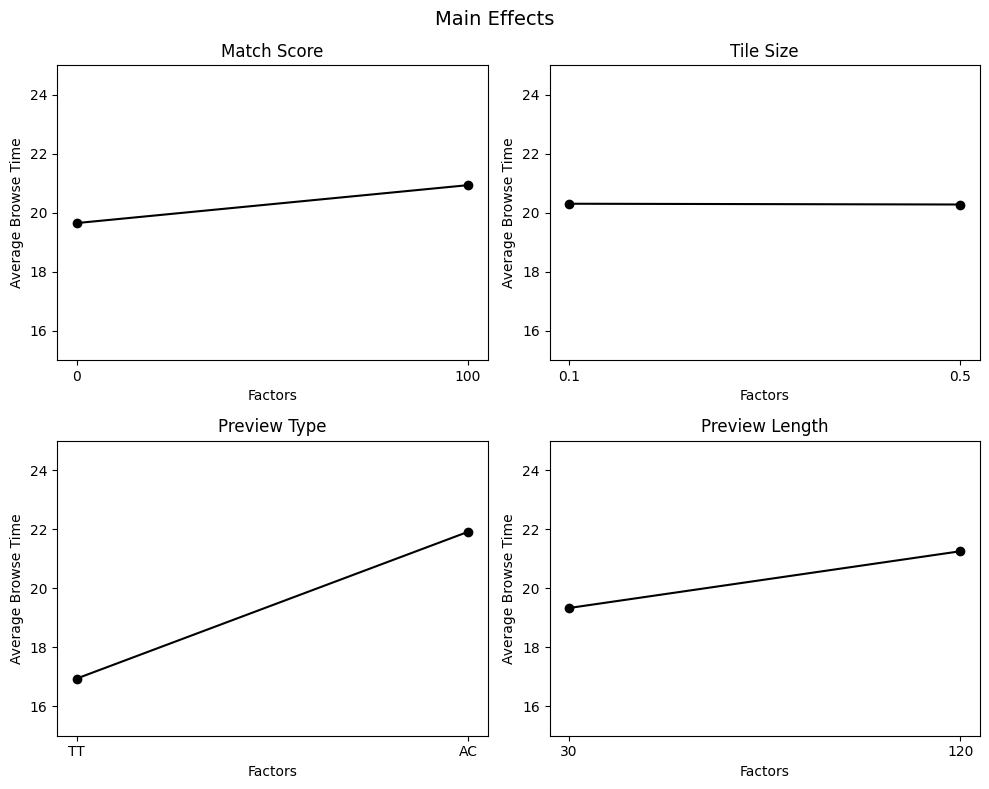

In [ ]:
# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(10,8))

# Set y-axis limits
ymin, ymax = 15, 25
for ax in axs.flat:
    ax.set_ylim(ymin, ymax)

# Match score chart
axs[0,0].scatter([1,2], [y_ms_50, y_ms_100], c="black")
axs[0,0].plot([1,2], [y_ms_50, y_ms_100], c="black")
axs[0,0].set_title("Match Score")
axs[0,0].set_xticks([1,2])
axs[0,0].set_xticklabels(['0','100'])
axs[0,0].set_ylabel("Average Browse Time")

# Tile size chart
axs[0,1].scatter([1,2], [y_ts_01, y_ts_05], c="black")
axs[0,1].plot([1,2], [y_ts_01, y_ts_05], c="black")
axs[0,1].set_title("Tile Size")
axs[0,1].set_xticks([1,2])
axs[0,1].set_xticklabels(['0.1','0.5'])

# Preview type chart
axs[1,0].scatter([1,2], [y_pt_tt, y_pt_ac], c="black")
axs[1,0].plot([1,2], [y_pt_tt, y_pt_ac], c="black")
axs[1,0].set_title("Preview Type")
axs[1,0].set_xticks([1,2])
axs[1,0].set_xticklabels(['TT','AC'])

# Preview length chart
axs[1,1].scatter([1,2], [y_pl_30, y_pl_120], c="black")
axs[1,1].plot([1,2], [y_pl_30, y_pl_120], c="black")
axs[1,1].set_title("Preview Length")
axs[1,1].set_xticks([1,2])
axs[1,1].set_xticklabels(['30','120'])

# Set common labels
for ax in axs.flat:
    ax.set_xlabel("Factors")
    ax.set_ylabel("Average Browse Time")

# Set overall figure title
fig.suptitle("Main Effects", fontsize=14)

# Adjust subplot spacing
fig.tight_layout()

# Show plot
plt.show()

In [ ]:
# Interaction term for tile_size:match_score
y_ts_ms_01_50 = df_2k.groupby(['tile_size', 'match_score']).get_group((0.1, 50))['browse_time'].mean()
y_ts_ms_05_50 = df_2k.groupby(['tile_size', 'match_score']).get_group((0.5, 50))['browse_time'].mean()
y_ts_ms_01_100 = df_2k.groupby(['tile_size', 'match_score']).get_group((0.1, 100))['browse_time'].mean()
y_ts_ms_05_100 = df_2k.groupby(['tile_size', 'match_score']).get_group((0.5, 100))['browse_time'].mean()

# Interaction term for tile_size:prev_length
y_ts_pl_01_30 = df_2k.groupby(['tile_size', 'prev_length']).get_group((0.1, 30))['browse_time'].mean()
y_ts_pl_05_120 = df_2k.groupby(['tile_size', 'prev_length']).get_group((0.5, 120))['browse_time'].mean()
y_ts_pl_01_30 = df_2k.groupby(['tile_size', 'prev_length']).get_group((0.1, 30))['browse_time'].mean()
y_ts_pl_05_120 = df_2k.groupby(['tile_size', 'prev_length']).get_group((0.5, 120))['browse_time'].mean()

# Interaction term for tile_size:prev_type
y_ts_pt_01_tt = df_2k.groupby(['tile_size', 'prev_type']).get_group((0.1, "TT"))['browse_time'].mean()
y_ts_pt_05_tt = df_2k.groupby(['tile_size', 'prev_type']).get_group((0.5, "TT"))['browse_time'].mean()
y_ts_pt_01_ac = df_2k.groupby(['tile_size', 'prev_type']).get_group((0.1, "AC"))['browse_time'].mean()
y_ts_pt_05_ac = df_2k.groupby(['tile_size', 'prev_type']).get_group((0.5, "AC"))['browse_time'].mean()

# Interaction term for match_score:prev_length
y_ms_pl_50_30 = df_2k.groupby(['match_score', 'prev_length']).get_group((50, 30))['browse_time'].mean()
y_ms_pl_100_30 = df_2k.groupby(['match_score', 'prev_length']).get_group((100, 30))['browse_time'].mean()
y_ms_pl_50_120 = df_2k.groupby(['match_score', 'prev_length']).get_group((50, 120))['browse_time'].mean()
y_ms_pl_100_120 = df_2k.groupby(['match_score', 'prev_length']).get_group((100, 120))['browse_time'].mean()

# Interaction term for match_score:prev_type
y_ms_pt_0_tt = df_2k.groupby(['match_score', 'prev_type']).get_group((50, "TT"))['browse_time'].mean()
y_ms_pt_100_tt = df_2k.groupby(['match_score', 'prev_type']).get_group((100, "TT"))['browse_time'].mean()
y_ms_pt_0_ac = df_2k.groupby(['match_score', 'prev_type']).get_group((50, "AC"))['browse_time'].mean()
y_ms_pt_100_ac = df_2k.groupby(['match_score', 'prev_type']).get_group((100, "AC"))['browse_time'].mean()

# Interaction term for prev_length:prev_type
y_pl_pt_30_tt = df_2k.groupby(['prev_length', 'prev_type']).get_group((30, "TT"))['browse_time'].mean()
y_pl_pt_120_tt = df_2k.groupby(['prev_length', 'prev_type']).get_group((120, "TT"))['browse_time'].mean()
y_pl_pt_30_ac = df_2k.groupby(['prev_length', 'prev_type']).get_group((30, "AC"))['browse_time'].mean()
y_pl_pt_120_ac = df_2k.groupby(['prev_length', 'prev_type']).get_group((120, "AC"))['browse_time'].mean()

In [ ]:
# # Interaction term for tile_size:match_score
# plt.figure()
# plt.scatter(x = [1,2,1,2], y = [y_ts_ms_01_50, y_ts_ms_05_50, y_ts_ms_01_100, y_ts_ms_05_100], c = "black")
# plt.ylabel("Average Browsing Time")
# plt.xlabel("Tile Size")
# plt.title("Tile Size by Match Score Interaction")
# plt.ylim(23,27)
# plt.xticks(ticks = [1,2], labels = ['0.1', '0.5'])
# ms0, = plt.plot([1,2], [y_ts_ms_01_50,y_ts_ms_05_50], c = "black", linestyle = "dashed", label = "Match Score = 0")
# ms100, = plt.plot([1,2], [y_ts_ms_01_100,y_ts_ms_05_100], c = "black", label = "Match Score = 100")
# plt.legend(handles = [ms0, ms100], loc = "upper left")
# plt.show()

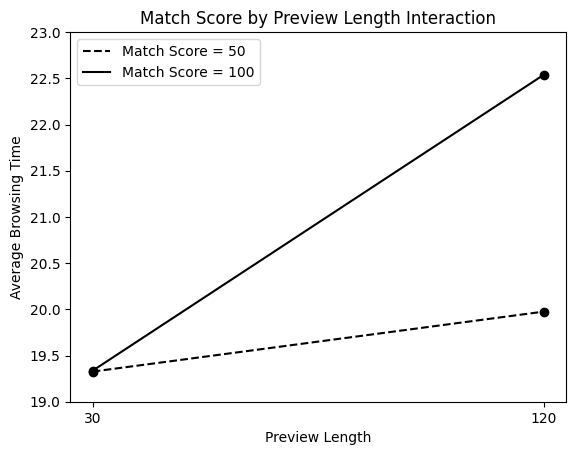

In [ ]:
# Interaction plot for match_score and prev_length
plt.figure()
plt.scatter(x = [1,2,1,2], y = [y_ms_pl_50_30, y_ms_pl_50_120, y_ms_pl_100_30, y_ms_pl_100_120], c="black")
plt.ylabel("Average Browsing Time")
plt.xlabel("Preview Length")
plt.title("Match Score by Preview Length Interaction")
plt.ylim(19, 23)
plt.xticks(ticks=[1,2], labels=['30','120'])
ms50, = plt.plot([1,2], [y_ms_pl_50_30, y_ms_pl_50_120], c = 'black', linestyle='dashed', label='Match Score = 50')
ms100, = plt.plot([1,2], [y_ms_pl_100_30, y_ms_pl_100_120], c = 'black', label='Match Score = 100')
plt.legend(handles=[ms50, ms100], loc='upper left')
plt.show()

## 1.3 Running Regressions

### 1.3.1 Coding the input at +/- 1

In [ ]:
def convertNtoC(U, UH, UL):
    x = (U - (UH+UL)/2) / ((UH-UL)/2)
    return x

def convertCtoN(x, UH, UL):
    U = x*(UH-UL)/2 + (UH+UL)/2
    return U

In [ ]:
# Define min, max
tile_size_min = 0.1
tile_size_max = 0.5

match_score_min = 50
match_score_max = 100

prev_length_min = 30
prev_length_max = 120

df_2k['tile_size_coded'] = df_2k['tile_size'].apply(lambda x: convertNtoC(x, tile_size_max, tile_size_min))
df_2k['match_score_coded'] = df_2k['match_score'].apply(lambda x: convertNtoC(x, match_score_max, match_score_min))
df_2k['prev_length_coded'] = df_2k['prev_length'].apply(lambda x: convertNtoC(x, prev_length_max, prev_length_min))

df_2k['prev_type_coded'] = df_2k['prev_type'].apply(lambda x: -1 if x == 'TT' else 1)

df_2k

,tile_size,match_score,prev_length,prev_type,browse_time,tile_size_coded,match_score_coded,prev_length_coded,prev_type_coded
0,0.1,50,30,TT,16.262870,-1.0,-1.0,-1.0,-1
1,0.1,50,30,AC,23.698750,-1.0,-1.0,-1.0,1
2,0.1,50,120,TT,17.621003,-1.0,-1.0,1.0,-1
3,0.1,50,120,AC,22.759854,-1.0,-1.0,1.0,1
4,0.1,100,30,TT,16.597786,-1.0,1.0,-1.0,-1
...,...,...,...,...,...,...,...,...,...
1795,0.5,100,30,AC,21.486627,1.0,1.0,-1.0,1
1796,0.5,100,120,TT,18.910817,1.0,1.0,1.0,-1
1797,0.5,100,120,AC,24.811816,1.0,1.0,1.0,1
1798,0.3,75,75,TT,8.969464,0.0,0.0,0.0,-1


### 1.3.2 Full Model

In [ ]:
full = smf.ols('browse_time ~ tile_size_coded * match_score_coded * prev_length_coded * prev_type_coded', data = df_2k).fit()
print(full.summary())

                            OLS Regression Results                            
Dep. Variable:            browse_time   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     131.5
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          3.68e-275
Time:                        00:57:27   Log-Likelihood:                -4306.4
No. Observations:                1800   AIC:                             8645.
Df Residuals:                    1784   BIC:                             8733.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### 1.3.3 Full Model with Curvature

In [ ]:
full_curve = smf.ols('browse_time ~ tile_size_coded * match_score_coded * prev_length_coded * prev_type_coded + I(match_score_coded**2) + I(prev_length_coded**2)', data = df_2k).fit()
print(full_curve.summary())

                            OLS Regression Results                            
Dep. Variable:            browse_time   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1574.
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:57:29   Log-Likelihood:                -2532.0
No. Observations:                1800   AIC:                             5098.
Df Residuals:                    1783   BIC:                             5191.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### 1.3.4 Reduced Model: No Tile Size

In [ ]:
red_no_ts = smf.ols('browse_time ~ match_score_coded * prev_length_coded * prev_type_coded', data = df_2k).fit()
print(red_no_ts.summary())

                            OLS Regression Results                            
Dep. Variable:            browse_time   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     282.5
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          6.56e-284
Time:                        00:57:35   Log-Likelihood:                -4307.6
No. Observations:                1800   AIC:                             8631.
Df Residuals:                    1792   BIC:                             8675.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

### 1.3.5 Reduce Model: Significant Factors only

In [ ]:
red_sf = smf.ols('browse_time ~ match_score_coded + prev_length_coded + prev_type_coded + match_score_coded:prev_length_coded', data = df_2k).fit()
print(red_sf.summary())

                            OLS Regression Results                            
Dep. Variable:            browse_time   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     495.1
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          7.53e-288
Time:                        00:57:38   Log-Likelihood:                -4307.6
No. Observations:                1800   AIC:                             8625.
Df Residuals:                    1795   BIC:                             8653.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

# 2.0 Central Composite Design

## 2.1 Read in the experiment .csv and process dataframe

In [ ]:
# csv_exp2 = drive_path + 'RESULTS_NSTEVENS_CumCondCount=93916_2024-01-18.csv'
# csv_exp2 = drive_path + 'RESULTS_NSTEVENS_CumCondCount=93904_2024-01-19.csv'
csv_exp2 = drive_path + 'RESULTS_td8sdswt_CumCondCount=26_2024-01-19.csv'

In [ ]:
df_ccd = pd.read_csv(csv_exp2)
df_ccd = df_ccd.rename(columns={
    'Tile.Size': 'tile_size',
    'Match.Score': 'match_score',
    'Prev.Length': 'prev_length',
    'Prev.Type': 'prev_type',
    'Browse.Time': 'browse_time'
})
df_ccd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   match_score  800 non-null    int64  
 1   prev_length  800 non-null    int64  
 2   prev_type    800 non-null    object 
 3   tile_size    800 non-null    float64
 4   browse_time  800 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 31.4+ KB


### 2.1.1 Concatenate experiment 1 and 2, drop tile size, encode columns, split into TT and AC dataframes

In [ ]:
# concatenate experiments and drop tile_size
df_full = pd.concat([df_ccd, df_2k])
df_full = df_full.drop(['tile_size', 'tile_size_coded'], axis=1)

# encode columns
match_score_min = 50
match_score_max = 100

prev_length_min = 30
prev_length_max = 120

df_full['match_score_coded'] = df_full['match_score'].apply(lambda x: convertNtoC(x, match_score_max, match_score_min))
df_full['prev_length_coded'] = df_full['prev_length'].apply(lambda x: convertNtoC(x, prev_length_max, prev_length_min))
df_full['prev_type_coded'] = df_full['prev_type'].apply(lambda x: -1 if x == 'TT' else 1)

df_full

,match_score,prev_length,prev_type,browse_time,match_score_coded,prev_length_coded,prev_type_coded
0,50,75,TT,15.446713,-1.0,0.0,-1
1,100,75,TT,14.861560,1.0,0.0,-1
2,50,75,AC,21.522103,-1.0,0.0,1
3,100,75,AC,20.862273,1.0,0.0,1
4,75,30,TT,15.049516,0.0,-1.0,-1
...,...,...,...,...,...,...,...
1795,100,30,AC,21.486627,1.0,-1.0,1
1796,100,120,TT,18.910817,1.0,1.0,-1
1797,100,120,AC,24.811816,1.0,1.0,1
1798,75,75,TT,8.969464,0.0,0.0,-1


In [ ]:
# split into TT and AC dataframes
df_full_tt = df_full[df_full['prev_type'] == 'TT']
df_full_ac = df_full[df_full['prev_type'] == 'AC']

## 2.2 Run Regressions

### 2.2.1 TT Model

In [ ]:
# full model with 2nd order terms
full_tt = smf.ols('browse_time ~ match_score_coded * prev_length_coded + I(match_score_coded**2) + I(prev_length_coded**2)', data = df_full_tt).fit()
print(full_tt.summary())

                            OLS Regression Results                            
Dep. Variable:            browse_time   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     567.3
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          4.94e-323
Time:                        00:57:49   Log-Likelihood:                -2334.9
No. Observations:                1300   AIC:                             4682.
Df Residuals:                    1294   BIC:                             4713.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

### 2.2.2 AC Model

In [ ]:
# full model with 2nd order terms
full_ac = smf.ols('browse_time ~ match_score_coded * prev_length_coded + I(match_score_coded**2) + I(prev_length_coded**2)', data = df_full_ac).fit()
print(full_ac.summary())

                            OLS Regression Results                            
Dep. Variable:            browse_time   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     565.7
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          1.88e-322
Time:                        00:57:51   Log-Likelihood:                -2335.2
No. Observations:                1300   AIC:                             4682.
Df Residuals:                    1294   BIC:                             4714.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

## 2.3 Plots

### 2.3.1 Coded Plots

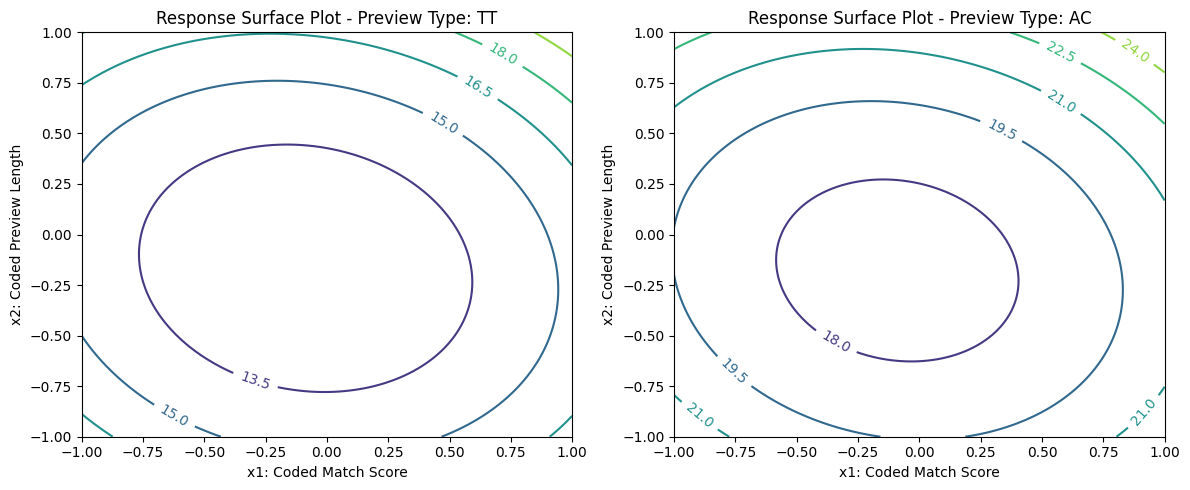

In [ ]:
beta_0_tt = full_tt.params[0]
beta_ms_tt = full_tt.params[1]
beta_pl_tt = full_tt.params[2]
beta_mspl_tt = full_tt.params[3]
beta_ms2_tt = full_tt.params[4]
beta_pl2_tt = full_tt.params[5]

beta_0_ac = full_ac.params[0]
beta_ms_ac = full_ac.params[1]
beta_pl_ac = full_ac.params[2]
beta_mspl_ac = full_ac.params[3]
beta_ms2_ac = full_ac.params[4]
beta_pl2_ac = full_ac.params[5]

# x1 is for Match Score, x2 is for Preview Length
x1, x2 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))

eta_tt = beta_0_tt + beta_ms_tt*x1 + beta_pl_tt*x2 + beta_mspl_tt*x1*x2 + beta_ms2_tt*x1**2 + beta_pl2_tt*x2**2
eta_ac = beta_0_ac + beta_ms_ac*x1 + beta_pl_ac*x2 + beta_mspl_ac*x1*x2 + beta_ms2_ac*x1**2 + beta_pl2_ac*x2**2

# Create figure with 2 axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# TT contour plot
eta_tt = beta_0_tt + beta_ms_tt*x1 + beta_pl_tt*x2 + beta_mspl_tt*x1*x2 + beta_ms2_tt*x1**2 + beta_pl2_tt*x2**2
h_tt = ax1.contour(x1, x2, eta_tt)
ax1.clabel(h_tt, inline=True, fontsize=10)
ax1.set_title('Response Surface Plot - Preview Type: TT')

# AC contour plot
eta_ac = beta_0_ac + beta_ms_ac*x1 + beta_pl_ac*x2 + beta_mspl_ac*x1*x2 + beta_ms2_ac*x1**2 + beta_pl2_ac*x2**2
h_ac = ax2.contour(x1, x2, eta_ac)
ax2.clabel(h_ac, inline=True, fontsize=10)
ax2.set_title('Response Surface Plot - Preview Type: AC')

# Common labels
for ax in [ax1, ax2]:
    ax.set_xlabel('x1: Coded Match Score')
    ax.set_ylabel('x2: Coded Preview Length')

plt.tight_layout()
plt.show()

### 2.3.2 Natural Unit Plots

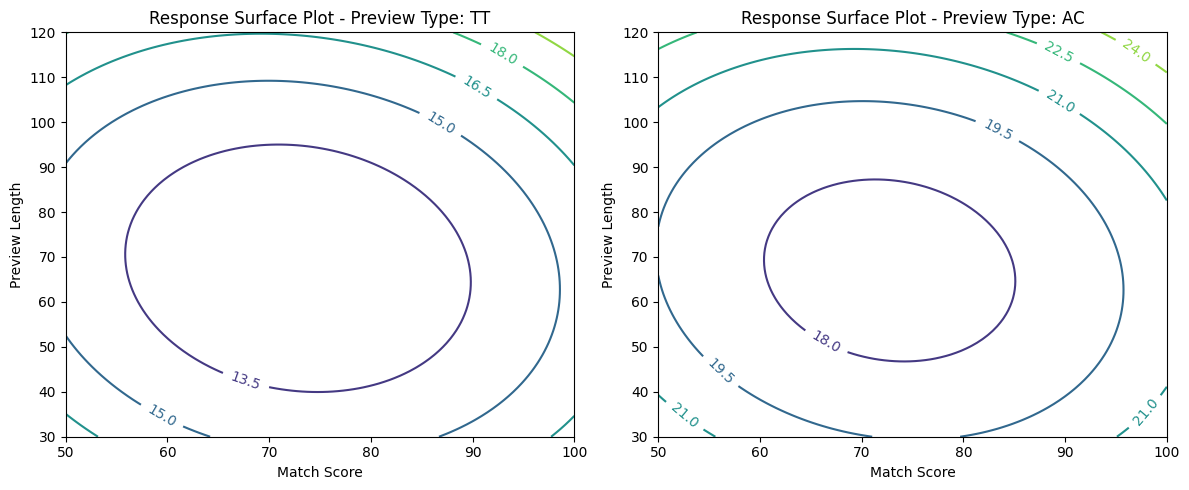

In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Grids
x1, x2 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x1_nat = convertCtoN(x1, UH=100, UL=50)
x2_nat = convertCtoN(x2, UH=120, UL=30)

# TT contour plot
h_tt = ax1.contour(x1_nat, x2_nat, eta_tt)
ax1.clabel(h_tt, inline=True, fontsize=10)
ax1.set_title('Response Surface Plot - Preview Type: TT')

# AC contour plot
h_ac = ax2.contour(x1_nat, x2_nat, eta_ac)
ax2.clabel(h_ac, inline=True, fontsize=10)
ax2.set_title('Response Surface Plot - Preview Type: AC')

# Labels
for ax in [ax1, ax2]:
    ax.set_xlabel('Match Score')
    ax.set_ylabel('Preview Length')

plt.tight_layout()
plt.show()

## 2.4 Determining the minimum point in natural units

### 2.4.1 TT Model

In [ ]:
b_tt = np.matrix([beta_ms_tt, beta_pl_tt]).transpose()
B_tt = np.matrix([[beta_ms2_tt, 0.5*beta_mspl_tt], [0.5*beta_mspl_tt, beta_pl2_tt]])
x_s_tt = -0.5* np.matmul(np.linalg.inv(B_tt), b_tt)
print("Browse Time is minimized when x1=", x_s_tt[0], "and x2=", x_s_tt[1])

Browse Time is minimized when x1= [[-0.08668717]] and x2= [[-0.16694802]]


In [ ]:
xsN_1_tt = convertCtoN(x = x_s_tt[0], UH = 100, UL = 50)
xsN_2_tt = convertCtoN(x = x_s_tt[1], UH = 120, UL = 30)
print("Match Score =", xsN_1_tt, ", Preview Length =", xsN_2_tt)

Match Score = [[72.83282072]] , Preview Length = [[67.48733907]]


In [ ]:
eta_s_tt = beta_0_tt + 0.5*np.matmul(x_s_tt.transpose(), b_tt)
print("Predicted Browse Time is ", eta_s_tt)

Predicted Browse Time is  [[12.34345939]]


In [ ]:
yhat_tt = full_tt.predict(exog=dict(match_score_coded=convertNtoC(U = 72, UH = 100, UL = 50),
                               prev_length_coded=convertNtoC(U = 70, UH = 120, UL = 30)))
print(yhat_tt)

0    12.354843
dtype: float64


In [ ]:
yhat_tt = full_tt.predict(exog=dict(match_score_coded=convertNtoC(U = 72, UH = 100, UL = 50),
                               prev_length_coded=convertNtoC(U = 65, UH = 120, UL = 30)))
print(yhat_tt)

0    12.357
dtype: float64


In [ ]:
yhat_tt = full_tt.predict(exog=dict(match_score_coded=convertNtoC(U = 73, UH = 100, UL = 50),
                               prev_length_coded=convertNtoC(U = 70, UH = 120, UL = 30)))
print(yhat_tt)

0    12.353562
dtype: float64


In [ ]:
# This is the lowest browse time given all practical levels
yhat_tt = full_tt.predict(exog=dict(match_score_coded=convertNtoC(U = 73, UH = 100, UL = 50),
                               prev_length_coded=convertNtoC(U = 65, UH = 120, UL = 30)))
print(yhat_tt)

0    12.352894
dtype: float64


In [ ]:
# find practical combination that generates the lowest browse time
lowest_yhat = float('inf')
best_ms = 0
best_pl = 0

for ms in [72, 73]:
    for pl in [65, 70]:


        yhat_tt = full_tt.predict(exog=dict(match_score_coded=convertNtoC(U=ms, UH=100, UL=50),
                                           prev_length_coded=convertNtoC(U=pl, UH=120, UL=30)))

        yhat_tt = yhat_tt.iloc[0]

        if yhat_tt < lowest_yhat:
            lowest_yhat = yhat_tt
            best_ms = ms
            best_pl = pl

print(f"Lowest predicted browse time: {lowest_yhat:.2f}")
print("Best match score:", best_ms)
print("Best preview length:", best_pl)

Lowest predicted browse time: 12.35
Best match score: 73
Best preview length: 65


This is a very similar prediction to what was observed at the true optimum. So given the convenience of a preview time of 65s and match score of 73, we might recommend that as a practical optimum for which we expect a browse time of 12.35 min.

### 2.4.2 AC Model

In [ ]:
b_ac = np.matrix([beta_ms_ac, beta_pl_ac]).transpose()
B_ac = np.matrix([[beta_ms2_ac, 0.5*beta_mspl_ac], [0.5*beta_mspl_ac, beta_pl2_ac]])
x_s_ac = -0.5* np.matmul(np.linalg.inv(B_ac), b_ac)
print("Browse Time is minimized when x1=", x_s_ac[0], "and x2=", x_s_ac[1])

Browse Time is minimized when x1= [[-0.08999865]] and x2= [[-0.17769124]]


In [ ]:
xsN_1_ac = convertCtoN(x = x_s_ac[0], UH = 100, UL = 50)
xsN_2_ac = convertCtoN(x = x_s_ac[1], UH = 120, UL = 30)
print("Match Score =", xsN_1_ac, ", Preview Length =", xsN_2_ac)

Match Score = [[72.75003387]] , Preview Length = [[67.00389433]]


In [ ]:
eta_s_ac = beta_0_ac + 0.5*np.matmul(x_s_ac.transpose(), b_ac)
print("Predicted Browse Time is ", eta_s_ac)

Predicted Browse Time is  [[17.39070567]]


In [ ]:
yhat_ac = full_ac.predict(exog=dict(match_score_coded=convertNtoC(U = 72, UH = 100, UL = 50),
                               prev_length_coded=convertNtoC(U = 70, UH = 120, UL = 30)))
print(yhat_ac)

0    17.405212
dtype: float64


In [ ]:
yhat_ac = full_ac.predict(exog=dict(match_score_coded=convertNtoC(U = 72, UH = 100, UL = 50),
                               prev_length_coded=convertNtoC(U = 65, UH = 120, UL = 30)))
print(yhat_ac)

0    17.39988
dtype: float64


In [ ]:
yhat_ac = full_ac.predict(exog=dict(match_score_coded=convertNtoC(U = 73, UH = 100, UL = 50),
                               prev_length_coded=convertNtoC(U = 70, UH = 120, UL = 30)))
print(yhat_ac)

0    17.404896
dtype: float64


In [ ]:
yhat_ac = full_ac.predict(exog=dict(match_score_coded=convertNtoC(U = 72, UH = 100, UL = 50),
                               prev_length_coded=convertNtoC(U = 65, UH = 120, UL = 30)))
print(yhat_ac)

0    17.39988
dtype: float64


In [ ]:
# find practical combination that generates the lowest browse time
lowest_yhat = float('inf')
best_ms = 0
best_pl = 0

for ms in [72, 73]:
    for pl in [65, 70]:


        yhat_ac = full_ac.predict(exog=dict(match_score_coded=convertNtoC(U=ms, UH=100, UL=50),
                                           prev_length_coded=convertNtoC(U=pl, UH=120, UL=30)))

        yhat_ac = yhat_ac.iloc[0]

        if yhat_ac < lowest_yhat:
            lowest_yhat = yhat_ac
            best_ms = ms
            best_pl = pl

print(f"Lowest predicted browse time: {lowest_yhat:.2f}")
print("Best match score:", best_ms)
print("Best preview length:", best_pl)

Lowest predicted browse time: 17.40
Best match score: 73
Best preview length: 65


## 2.5 Confirmation Experiments
Based on 2.4, the minimum browse time is when
* Match Score: 73
* Preview Length: 65
* Preview Type: TT

### [X NOT NEEDED] Running the full experiment with all data collected to determine if we can get a more fine-grained look at the optimum

In [ ]:
csv_exp3 = drive_path + 'RESULTS_td8sdswt_CumCondCount=27_2024-01-19.csv'

In [ ]:
df_exp3 = pd.read_csv(csv_exp3)
df_exp3 = df_exp3.rename(columns={
    'Tile.Size': 'tile_size',
    'Match.Score': 'match_score',
    'Prev.Length': 'prev_length',
    'Prev.Type': 'prev_type',
    'Browse.Time': 'browse_time'
})
df_exp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   match_score  100 non-null    int64  
 1   prev_length  100 non-null    int64  
 2   prev_type    100 non-null    object 
 3   tile_size    100 non-null    float64
 4   browse_time  100 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.0+ KB


In [ ]:
# concatenate experiments and drop tile_size
df_full_2 = pd.concat([df_full, df_exp3])
df_full_2 = df_full_2.drop(['tile_size'], axis=1)

# encode columns
match_score_min = 50
match_score_max = 100

prev_length_min = 30
prev_length_max = 120

df_full_2['match_score_coded'] = df_full_2['match_score'].apply(lambda x: convertNtoC(x, match_score_max, match_score_min))
df_full_2['prev_length_coded'] = df_full_2['prev_length'].apply(lambda x: convertNtoC(x, prev_length_max, prev_length_min))
df_full_2['prev_type_coded'] = df_full_2['prev_type'].apply(lambda x: -1 if x == 'TT' else 1)

df_full_2

,match_score,prev_length,prev_type,browse_time,match_score_coded,prev_length_coded,prev_type_coded
0,50,75,TT,15.446713,-1.00,0.000000,-1
1,100,75,TT,14.861560,1.00,0.000000,-1
2,50,75,AC,21.522103,-1.00,0.000000,1
3,100,75,AC,20.862273,1.00,0.000000,1
4,75,30,TT,15.049516,0.00,-1.000000,-1
...,...,...,...,...,...,...,...
95,73,65,TT,10.455420,-0.08,-0.222222,-1
96,73,65,TT,9.326187,-0.08,-0.222222,-1
97,73,65,TT,10.497297,-0.08,-0.222222,-1
98,73,65,TT,11.703181,-0.08,-0.222222,-1


In [ ]:
df_full_2_tt = df_full_2[df_full_2['prev_type'] == 'TT']

In [ ]:
# full model with 2nd order terms
full_2_tt = smf.ols('browse_time ~ match_score_coded * prev_length_coded + I(match_score_coded**2) + I(prev_length_coded**2)', data = df_full_2_tt).fit()
print(full_2_tt.summary())

                            OLS Regression Results                            
Dep. Variable:            browse_time   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     856.6
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        01:00:23   Log-Likelihood:                -2527.2
No. Observations:                1400   AIC:                             5066.
Df Residuals:                    1394   BIC:                             5098.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

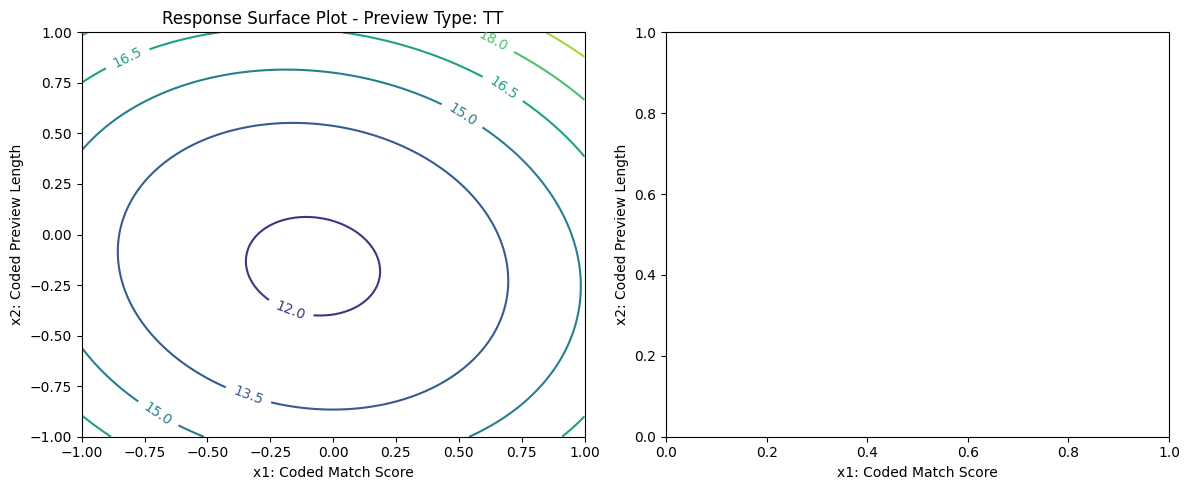

In [ ]:
beta_0_2_tt = full_2_tt.params[0]
beta_ms_2_tt = full_2_tt.params[1]
beta_pl_2_tt = full_2_tt.params[2]
beta_mspl_2_tt = full_2_tt.params[3]
beta_ms2_2_tt = full_2_tt.params[4]
beta_pl2_2_tt = full_2_tt.params[5]

# x1 is for Match Score, x2 is for Preview Length
x1, x2 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))

eta_2_tt = beta_0_2_tt + beta_ms_2_tt*x1 + beta_pl_2_tt*x2 + beta_mspl_2_tt*x1*x2 + beta_ms2_2_tt*x1**2 + beta_pl2_2_tt*x2**2

# Create figure with 2 axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# TT contour plot
eta_2_tt = beta_0_2_tt + beta_ms_2_tt*x1 + beta_pl_2_tt*x2 + beta_mspl_2_tt*x1*x2 + beta_ms2_2_tt*x1**2 + beta_pl2_2_tt*x2**2
h_2_tt = ax1.contour(x1, x2, eta_2_tt)
ax1.clabel(h_2_tt, inline=True, fontsize=10)
ax1.set_title('Response Surface Plot - Preview Type: TT')

# Common labels
for ax in [ax1, ax2]:
    ax.set_xlabel('x1: Coded Match Score')
    ax.set_ylabel('x2: Coded Preview Length')

plt.tight_layout()
plt.show()

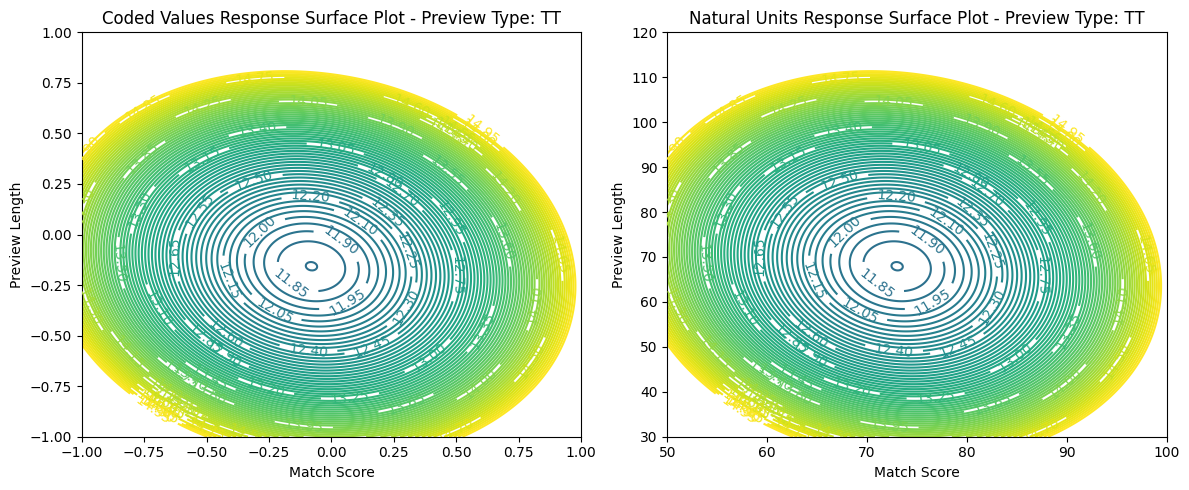

In [ ]:
# Finer-grained contours
# Create figure with 2 axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Grids
x1, x2 = np.meshgrid(np.linspace(-1, 1, 1000), np.linspace(-1, 1, 1000))
x1_nat = convertCtoN(x1, UH=100, UL=50)
x2_nat = convertCtoN(x2, UH=120, UL=30)

eta_2_tt = beta_0_2_tt + beta_ms_2_tt*x1 + beta_pl_2_tt*x2 + beta_mspl_2_tt*x1*x2 + beta_ms2_2_tt*x1**2 + beta_pl2_2_tt*x2**2

levels = np.arange(10, 15, 0.05)

# Coded values contour plot
h1_2 = ax1.contour(x1, x2, eta_2_tt, levels=levels)
ax1.clabel(h1_2, inline=True, fontsize=10)
ax1.set_title('Coded Values Response Surface Plot - Preview Type: TT')

# Natural units contour plot
h2_2 = ax2.contour(x1_nat, x2_nat, eta_2_tt, levels=levels)
ax2.clabel(h2_2, inline=True, fontsize=10)
ax2.set_title('Natural Units Response Surface Plot - Preview Type: TT')

# Common labels
for ax in [ax1, ax2]:
    ax.set_xlabel('Match Score')
    ax.set_ylabel('Preview Length')

plt.tight_layout()
plt.show()

### 2.5.1 Using actual data to determine average browse time

In [ ]:
df_full_3 = pd.concat([df_2k, df_ccd, df_exp3])
df_full_3 = df_full_3.drop(['tile_size_coded', 'match_score_coded', 'prev_length_coded', 'prev_type_coded'], axis=1)
df_full_3

,tile_size,match_score,prev_length,prev_type,browse_time
0,0.1,50,30,TT,16.262870
1,0.1,50,30,AC,23.698750
2,0.1,50,120,TT,17.621003
3,0.1,50,120,AC,22.759854
4,0.1,100,30,TT,16.597786
...,...,...,...,...,...
95,0.2,73,65,TT,10.455420
96,0.2,73,65,TT,9.326187
97,0.2,73,65,TT,10.497297
98,0.2,73,65,TT,11.703181


In [ ]:
df_full_3_mean = df_full_3.groupby(['match_score', 'prev_length', 'prev_type'])['browse_time'].mean()
df_full_3_mean

match_score  prev_length  prev_type
50           30           AC           21.777024
                          TT           16.875266
             75           AC           21.117973
                          TT           16.003991
             120          AC           22.449678
                          TT           17.500261
73           65           TT           10.740789
75           30           AC           20.028540
                          TT           15.131676
             75           AC           14.997825
                          TT            9.959197
             120          AC           23.622400
                          TT           18.541555
100          30           AC           21.824460
                          TT           16.848157
             75           AC           21.491047
                          TT           16.484542
             120          AC           25.058940
                          TT           20.015655
Name: browse_time, dtype: float64

In [ ]:
csv_exp4 = drive_path + 'RESULTS_td8sdswt_CumCondCount=28_2024-01-19.csv'
df_exp4 = pd.read_csv(csv_exp4)
df_exp4 = df_exp4.rename(columns={
    'Tile.Size': 'tile_size',
    'Match.Score': 'match_score',
    'Prev.Length': 'prev_length',
    'Prev.Type': 'prev_type',
    'Browse.Time': 'browse_time'
})
df_exp4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   match_score  100 non-null    int64  
 1   prev_length  100 non-null    int64  
 2   prev_type    100 non-null    object 
 3   tile_size    100 non-null    float64
 4   browse_time  100 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 4.0+ KB


In [ ]:
df_full_4 = pd.concat([df_full_3, df_exp4])
df_full_4 = df_full_4.drop(['tile_size'], axis=1)
df_full_4

,match_score,prev_length,prev_type,browse_time
0,50,30,TT,16.262870
1,50,30,AC,23.698750
2,50,120,TT,17.621003
3,50,120,AC,22.759854
4,100,30,TT,16.597786
...,...,...,...,...
95,76,80,TT,10.965886
96,76,80,TT,10.448251
97,76,80,TT,12.421969
98,76,80,TT,9.509841


In [ ]:
df_full_4_mean = df_full_4.groupby(['match_score', 'prev_length', 'prev_type'])['browse_time'].mean()
df_full_4_mean

match_score  prev_length  prev_type
50           30           AC           21.777024
                          TT           16.875266
             75           AC           21.117973
                          TT           16.003991
             120          AC           22.449678
                          TT           17.500261
73           65           TT           10.740789
75           30           AC           20.028540
                          TT           15.131676
             75           AC           14.997825
                          TT            9.959197
             120          AC           23.622400
                          TT           18.541555
76           80           TT           10.487453
100          30           AC           21.824460
                          TT           16.848157
             75           AC           21.491047
                          TT           16.484542
             120          AC           25.058940
                          TT     

In [ ]:
# # Create figure
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# # Grids
# x1, x2 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
# x1_nat = convertCtoN(x1, UH=100, UL=50)
# x2_nat = convertCtoN(x2, UH=120, UL=30)

# # TT contour plot
# h_2_tt = ax1.contour(x1_nat, x2_nat, eta_2_tt)
# ax1.clabel(h_2_tt, inline=True, fontsize=10)
# ax1.set_title('Response Surface Plot - Preview Type: TT')

# # Labels
# for ax in [ax1, ax2]:
#     ax.set_xlabel('Match Score')
#     ax.set_ylabel('Preview Length')

# plt.tight_layout()
# plt.show()

In [ ]:
b_2_tt = np.matrix([beta_ms_2_tt, beta_pl_2_tt]).transpose()
B_2_tt = np.matrix([[beta_ms2_2_tt, 0.5*beta_mspl_2_tt], [0.5*beta_mspl_2_tt, beta_pl2_2_tt]])
x_s_2_tt = -0.5* np.matmul(np.linalg.inv(B_2_tt), b_2_tt)
print("Browse Time is minimiz==ed when x1=", x_s_2_tt[0], "and x2=", x_s_2_tt[1])

Browse Time is minimiz==ed when x1= [[-0.07979277]] and x2= [[-0.15682549]]


In [ ]:
xsN_1_2_tt = convertCtoN(x = x_s_2_tt[0], UH = 100, UL = 50)
xsN_2_2_tt = convertCtoN(x = x_s_2_tt[1], UH = 120, UL = 30)
print("Match Score =", xsN_1_2_tt, ", Preview Length =", xsN_2_2_tt)

Match Score = [[73.00518073]] , Preview Length = [[67.94285283]]


In [ ]:
eta_s_2_tt = beta_0_2_tt + 0.5*np.matmul(x_s_2_tt.transpose(), b_2_tt)
print("Predicted Browse Time is ", eta_s_2_tt)

Predicted Browse Time is  [[11.7985492]]


In [ ]:
yhat_2_tt = full_2_tt.predict(exog=dict(match_score_coded=convertNtoC(U = 73, UH = 100, UL = 50),
                               prev_length_coded=convertNtoC(U = 65, UH = 120, UL = 30)))
print(yhat_2_tt)

0    11.813186
dtype: float64


In [ ]:
yhat_2_tt - yhat_tt

0   -0.539709
dtype: float64

In [ ]:
# find practical combination that generates the lowest browse time
lowest_yhat = float('inf')
best_ms = 0
best_pl = 0

for ms in [72, 74]:
    for pl in [65, 70]:


        yhat_2_tt = full_2_tt.predict(exog=dict(match_score_coded=convertNtoC(U=ms, UH=100, UL=50),
                                           prev_length_coded=convertNtoC(U=pl, UH=120, UL=30)))

        yhat_2_tt = yhat_2_tt.iloc[0]

        if yhat_2_tt < lowest_yhat:
            lowest_yhat = yhat_2_tt
            best_ms = ms
            best_pl = pl

print(f"Lowest predicted browse time: {lowest_yhat:.2f}")
print("Best match score:", best_ms)
print("Best preview length:", best_pl)

Lowest predicted browse time: 11.81
Best match score: 72
Best preview length: 70


### 2.5.2 Calculating the confidence interval

#### 2.5.2.1 MS 73, PL 65

In [ ]:
# csv_exp3 = drive_path + 'RESULTS_NSTEVENS_CumCondCount=93959_2024-01-19.csv'
# csv_exp3 = drive_path + 'RESULTS_NSTEVENS_CumCondCount=93905_2024-01-19.csv'
csv_exp3 = drive_path + 'RESULTS_td8sdswt_CumCondCount=27_2024-01-19.csv'

In [ ]:
df_con = pd.read_csv(csv_exp3)
df_con = df_con.rename(columns={
    'Tile.Size': 'tile_size',
    'Match.Score': 'match_score',
    'Prev.Length': 'prev_length',
    'Prev.Type': 'prev_type',
    'Browse.Time': 'browse_time'
})

In [ ]:
mean_1 = df_con['browse_time'].mean()
std_1 = df_con['browse_time'].std(ddof=1)
n_1 = len(df_con)

margin_of_error_1 = std_1 * stats.t.ppf((1 + 0.95) / 2, n_1-1)

lower_1 = mean_1 - margin_of_error_1
upper_1 = mean_1 + margin_of_error_1

print('95% Confidence Interval for Browse Time:')
print('[{0:.2f}, {1:.2f}]'.format(lower_1, upper_1))

95% Confidence Interval for Browse Time:
[8.80, 12.68]


In [ ]:
mean_1

10.740788513758302

#### 2.5.2.2 MS 76, PL 80

In [ ]:
mean_2 = df_exp4['browse_time'].mean()
std_2 = df_exp4['browse_time'].std(ddof=1)
n_2 = len(df_exp4)

margin_of_error_2 = std_2 * stats.t.ppf((1 + 0.95) / 2, n_2-1)

lower_2 = mean_2 - margin_of_error_2
upper_2 = mean_2 + margin_of_error_2

print('95% Confidence Interval for Browse Time:')
print('[{0:.2f}, {1:.2f}]'.format(lower_2, upper_2))

95% Confidence Interval for Browse Time:
[8.39, 12.59]


In [ ]:
mean_2

10.487453398177173

#### 2.5.2.3 MS 75, PL 75

In [ ]:
df_full_75_75 = df_full_4[(df_full_4['match_score'] == 75) & (df_full_4['prev_length'] == 75) & (df_full_4['prev_type'] == 'TT')]

In [ ]:
mean_3 = df_full_75_75['browse_time'].mean()
std_3 = df_full_75_75['browse_time'].std(ddof=1)
n_3 = len(df_full_75_75)

margin_of_error_3 = std_3 * stats.t.ppf((1 + 0.95) / 2, n_3-1)

lower_3 = mean_3 - margin_of_error_3
upper_3 = mean_3 + margin_of_error_3

print('95% Confidence Interval for Browse Time:')
print('[{0:.2f}, {1:.2f}]'.format(lower_3, upper_3))

95% Confidence Interval for Browse Time:
[7.86, 12.06]


In [ ]:
mean_3

9.959197141301926

### 2.5.3 t-test

In [ ]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(df_con['browse_time'], df_full_75_75['browse_time'], alternative = 'greater')

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.3e}")

alpha = 0.05
if p_val < alpha:
    print("Reject H0, means are significantly different.")
else:
    print("Fail to reject H0, means are not significantly different.")

t-statistic: 5.429
p-value: 8.240e-08
Reject H0, means are significantly different.


In [ ]:
t_stat, p_val = ttest_ind(df_exp4['browse_time'], df_full_75_75['browse_time'], alternative = 'greater')

print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_val:.3e}")

alpha = 0.05
if p_val < alpha:
    print("Reject H0, means are significantly different.")
else:
    print("Fail to reject H0, means are not significantly different.")

t-statistic: 3.531
p-value: 2.579e-04
Reject H0, means are significantly different.
